In [1]:
import os
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib as mlp

from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# dev = 'cpu'
if torch.cuda.is_available(): 
    dev = "cuda:0" 
else: 
    dev = "cpu" 
device = torch.device(dev) 

In [3]:
data_path = '/home/z5370003/projects/neuralops-l63/data/l63'

In [4]:
# Data path
mesh_path = os.path.join(data_path, 'mesh.npy')
pdfn_path = os.path.join(data_path, 'post.npy')

# Read numpy matrices
mesh = torch.from_numpy(np.load(mesh_path).reshape((1, 40, 40, 40, 3)))
pdfn = torch.from_numpy(np.load(pdfn_path).reshape((-1, 40, 40, 40, 1)))

pdfn = pdfn[:166]
pdfn = pdfn.repeat((3, 1, 1, 1, 1))

In [5]:
pdf2d = pdfn.sum(dim=3).squeeze(-1)

# m, n = 3, 3
# ind = np.linspace(0, 198, m*n).astype(int).reshape((m, n))

# fig, ax = plt.subplots(m, n, figsize=(8, 10))

# for i in range(3):
#     for j in range(3):
#         ax[i, j].imshow(pdf2d[ind[i, j]])
#         ax[i, j].set_title(f'{ind[i, j]+1}')


In [6]:
# pdfflat = pdf2d.view(499, -1)
pdfmin = pdf2d.min() #pdfflat.min(-1).values.reshape(-1, 1, 1).repeat((1, 40, 40))
pdfmax = pdf2d.max() # pdfflat.max(-1).values.reshape(-1, 1, 1).repeat((1, 40, 40))
pdf2d = ((pdf2d - pdfmin)/(pdfmax - pdfmin))

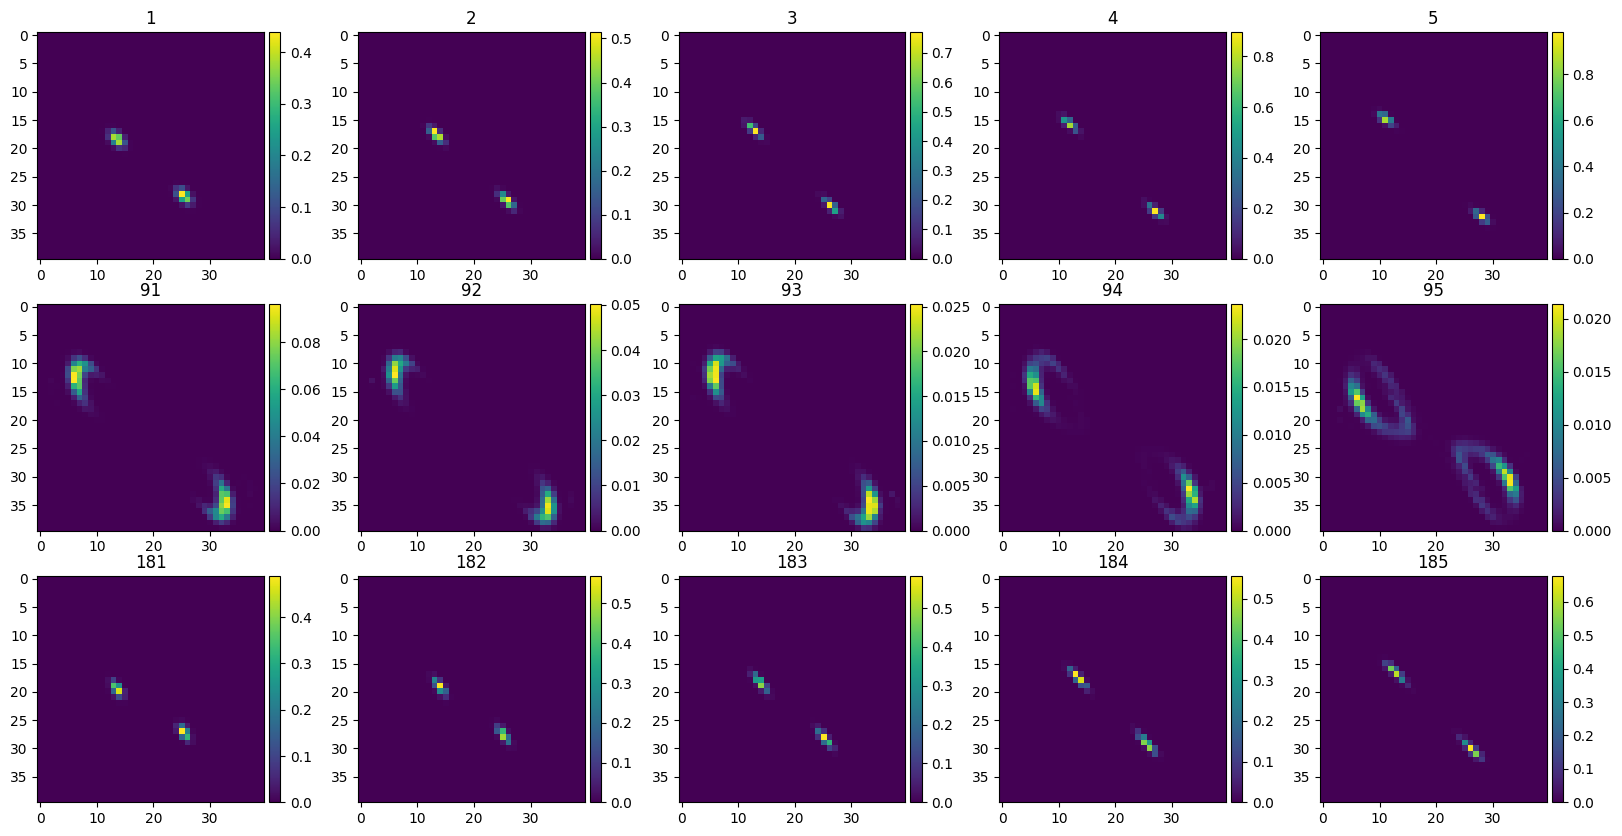

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

m, n = 3, 5
ind = np.linspace(0, 180, m).astype(int)

fig, ax = plt.subplots(m, n, figsize=(20,10))

for i in range(m):
    for j in range(n):
        im = ax[i, j].imshow(pdf2d[ind[i]+j])
        ax[i, j].set_title(f'{ind[i]+j+1}')

        divider = make_axes_locatable(ax[i, j])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')

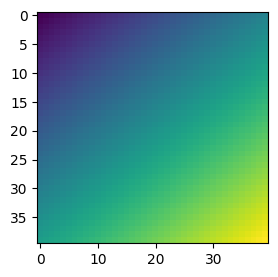

In [8]:
mesh2d = mesh.mean(-2)[...,:-1]
fig = plt.figure(figsize=(3, 3))
plt.imshow(mesh2d[0].sum(-1))

In [9]:
p = torch.concat([pdf2d.unsqueeze(-1), mesh2d.repeat(pdf2d.shape[0], 1, 1, 1)],
                 dim=-1)
p = torch.concat([p, p[-2:]], dim=0)
# p = torch.concat([p, ts], dim=-1)
p.shape

torch.Size([500, 40, 40, 3])

In [10]:
from torch.utils.data import  Dataset
class DictDataset(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        return {'x': x, 'y': y}
    
    def __len__(self):
        return len(self.data)

In [11]:
def get_dataset(p, n_steps=10):
    xs = []
    ys = []
    for i in range(0, p.shape[0]-2*n_steps):
        xs.append(p[i: i+n_steps])
        ys.append(p[i+n_steps:i+2*n_steps, ..., 0].unsqueeze(-1))
    x = torch.stack(xs, dim=0).permute(0, 4, 1, 2, 3)
    y = torch.stack(ys, dim=0).permute(0, 4, 1, 2, 3)
    return DictDataset(x, y)

In [12]:
full_ds = get_dataset(p, n_steps=5)
train_size = int(0.7 * len(full_ds))
test_size = len(full_ds) - train_size
train_ds, test_ds = torch.utils.data.random_split(full_ds, 
                                                  [train_size, test_size])


In [13]:
full_ds[0]['y'].shape

torch.Size([1, 5, 40, 40])

In [14]:
batch_size = 32
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

In [15]:
!pwd

/home/z5370003/projects/neuralops-l63


In [16]:
import sys
from models.fno import FNO
from neuralop.training import Trainer
from neuralop.utils import count_model_params
from models.losses import LpLoss, H1Loss

In [17]:
model = FNO(n_modes=(3, 16, 16), hidden_channels=32, 
            projection_channels=64, rank=0.42)
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 3554593 parameters.


In [18]:
optimizer = torch.optim.Adam(model.parameters(), 
                                lr=1e-2, 
                                weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)


l2loss = LpLoss(d=3, p=2)
h1loss = H1Loss(d=3)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}

In [19]:
print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()


### MODEL ###
 FNO(
  (lifting): MLP(
    (fcs): ModuleList(
      (0): Conv3d(3, 256, kernel_size=(1, 1, 1), stride=(1, 1, 1))
      (1): Conv3d(256, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    )
  )
  (projection): MLP(
    (fcs): ModuleList(
      (0): Conv3d(32, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1))
      (1): Conv3d(64, 1, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    )
  )
  (convs): SpectralConv(
    (weight): ModuleList(
      (0-3): 4 x ComplexDenseTensor(shape=torch.Size([32, 32, 3, 16, 9]), rank=None)
    )
  )
  (fno_skips): ModuleList(
    (0-3): 4 x Conv3d(32, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
  )
)

### OPTIMIZER ###
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.01
    lr: 0.01
    maximize: False
    weight_decay: 0.0001
)

### SCHEDULER ###

### LOSSES ###

 * Train: <models.losses.H1Loss object at 

In [20]:
n_epochs = 500

train_losses = []
test_losses = []


for epoch in range(n_epochs):

    avg_loss = 0
    avg_lasso_loss = 0
    model.train()
    train_err = 0.0
    
    avg_test_loss = 0
    test_err = 0.0

    for idx, sample in enumerate(train_dl):

        # load everything from the batch onto self.device if 
        # no callback overrides default load to device
        

        for k,v in sample.items():
            if hasattr(v, 'to'):
                sample[k] = v.to(device)

        optimizer.zero_grad(set_to_none=True)
        out = model(**sample)

        loss = 0.
        
        if isinstance(out, torch.Tensor):
            loss = train_loss(out.float(), **sample)
        elif isinstance(out, dict):
            loss += train_loss(**out, **sample)
        
        del out
        
        loss.backward()
        
        optimizer.step()
        train_err += loss.item()

        with torch.no_grad():
            avg_loss += loss.item()

    if epoch + 1 % 5:
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(train_err)
        else:
            scheduler.step()

    train_err /= len(train_dl)
    avg_loss  /= n_epochs
    
    

    
    if epoch == 0 or (epoch + 1) % 10 == 0:
        model.eval()
        for idx, sample in enumerate(test_dl):

            # load everything from the batch onto self.device if 
            # no callback overrides default load to device


            for k,v in sample.items():
                if hasattr(v, 'to'):
                    sample[k] = v.to(device)

            optimizer.zero_grad(set_to_none=True)
            out = model(**sample)

            loss = 0.

            if isinstance(out, torch.Tensor):
                loss = train_loss(out.float(), **sample)
            elif isinstance(out, dict):
                loss += train_loss(**out, **sample)

            del out

            test_err += loss.item()

            with torch.no_grad():
                avg_test_loss += loss.item()

        test_err /= len(test_dl)
        avg_test_loss  /= n_epochs
        
        
        train_losses.append(avg_loss)
        test_losses.append(avg_test_loss)
        
        print(f'Epoch: {epoch+1} loss: {avg_loss:.4f}  test loss: {avg_test_loss:.4f} lr: {scheduler.get_last_lr()[0]:.4f}, {optimizer.state_dict()["param_groups"][0]["lr"]:.4f}')

Epoch: 1 loss: 2.4119  test loss: 0.3055 lr: 0.0099, 0.0099
Epoch: 10 loss: 0.6550  test loss: 0.2854 lr: 0.0090, 0.0090
Epoch: 20 loss: 0.6523  test loss: 0.2845 lr: 0.0082, 0.0082
Epoch: 30 loss: 0.5619  test loss: 0.2614 lr: 0.0074, 0.0074
Epoch: 40 loss: 0.2847  test loss: 0.1220 lr: 0.0067, 0.0067
Epoch: 50 loss: 0.1904  test loss: 0.0854 lr: 0.0061, 0.0061
Epoch: 60 loss: 0.1685  test loss: 0.0698 lr: 0.0055, 0.0055
Epoch: 70 loss: 0.1454  test loss: 0.0646 lr: 0.0049, 0.0049
Epoch: 80 loss: 0.1195  test loss: 0.0573 lr: 0.0045, 0.0045
Epoch: 90 loss: 0.1065  test loss: 0.0537 lr: 0.0040, 0.0040
Epoch: 100 loss: 0.1029  test loss: 0.0500 lr: 0.0037, 0.0037
Epoch: 110 loss: 0.0957  test loss: 0.0473 lr: 0.0033, 0.0033
Epoch: 120 loss: 0.0908  test loss: 0.0486 lr: 0.0030, 0.0030
Epoch: 130 loss: 0.0847  test loss: 0.0444 lr: 0.0027, 0.0027
Epoch: 140 loss: 0.0818  test loss: 0.0407 lr: 0.0024, 0.0024
Epoch: 150 loss: 0.0797  test loss: 0.0405 lr: 0.0022, 0.0022
Epoch: 160 loss: 0.

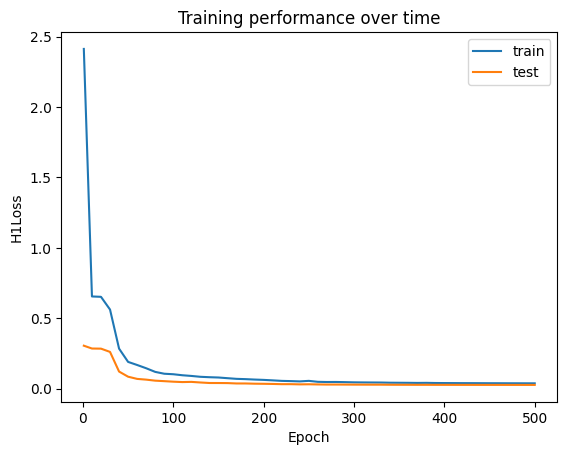

In [21]:
fig, ax = plt.subplots()

log_epochs = np.insert(np.arange(0, n_epochs, 10) + 10, 0, 1)

ax.plot(log_epochs, train_losses, label='train')
ax.plot(log_epochs, test_losses, label='test')

ax.set_title('Training performance over time')
ax.set_ylabel('H1Loss')
ax.set_xlabel('Epoch')
ax.legend()


Text(0.5, 1.0, 'FNO')

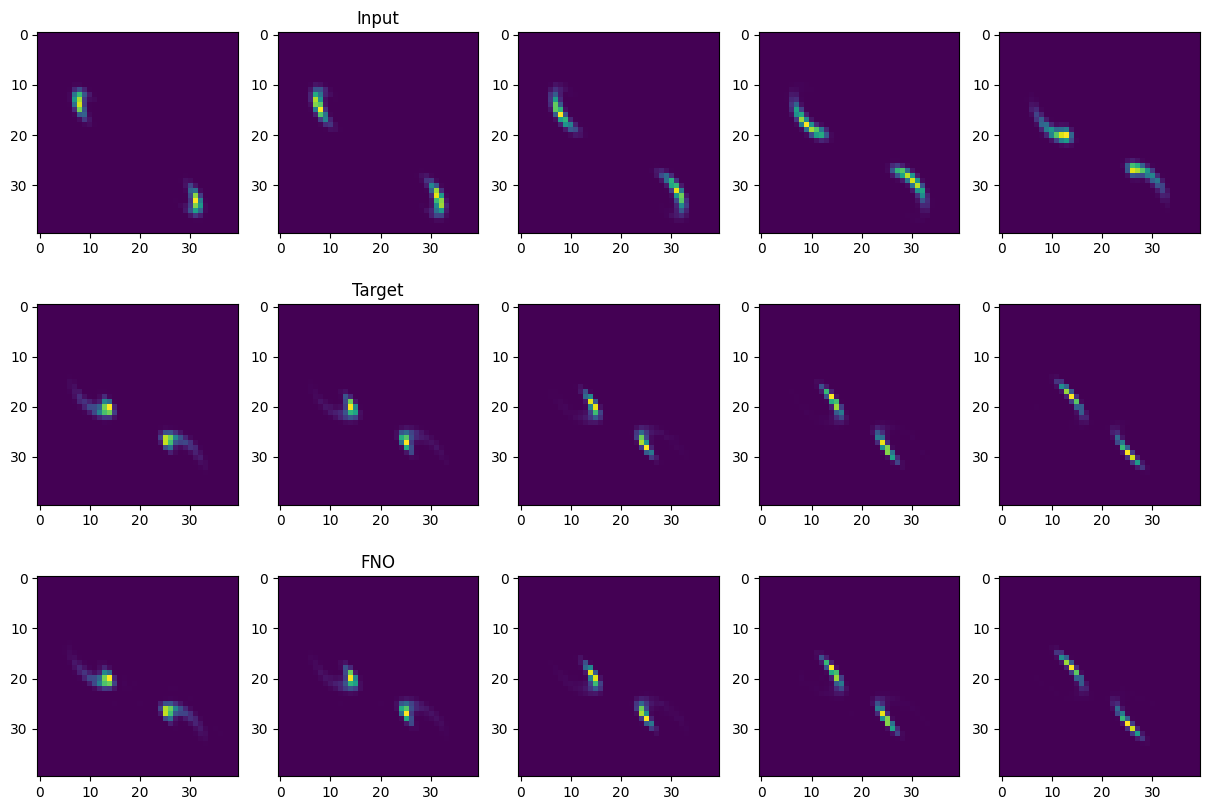

In [22]:
ind = np.random.randint(len(train_ds))

sample = train_ds[ind]
a = sample['x'].to(device)
p = sample['y'].to(device)

fig, ax = plt.subplots(3, a.shape[1], figsize=(a.shape[1]*3,10))


for j in range(a.shape[1]):
    ax[0, j].imshow(a[0, j, ...].cpu())
ax[0, 1].set_title("Input")


for j in range(a.shape[1]):
    ax[1, j].imshow(p[0, j, ...].cpu())
ax[1, 1].set_title("Target")

pred = model(a.unsqueeze(0)).relu()[0].cpu().detach().numpy()

for j in range(a.shape[1]):
    ax[2, j].imshow(pred[0, j, ...])

ax[2, 1].set_title("FNO")

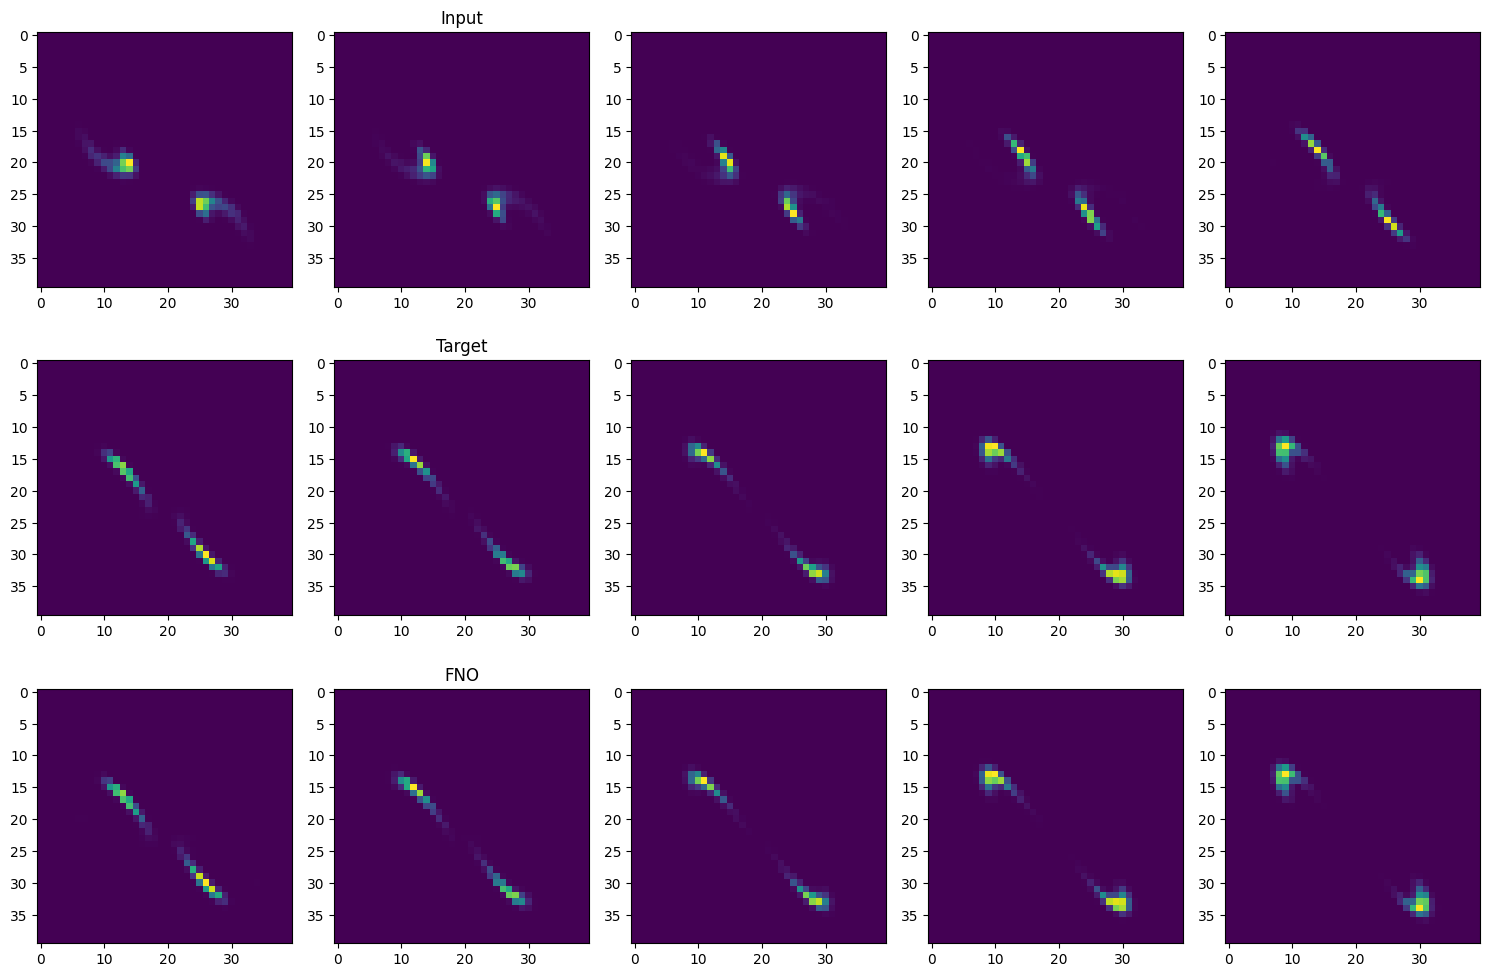

In [23]:
ind = np.random.randint(len(test_ds))

sample = test_ds[ind]
a = sample['x'].to(device)
p = sample['y'].to(device)

fig, ax = plt.subplots(3, a.shape[1], figsize=(a.shape[1]*3,10))


for j in range(a.shape[1]):
    ax[0, j].imshow(a[0, j, ...].cpu())
ax[0, 1].set_title("Input")


for j in range(a.shape[1]):
    ax[1, j].imshow(p[0, j, ...].cpu())
ax[1, 1].set_title("Target")

pred = model(a.unsqueeze(0)).relu()[0].cpu().detach().numpy()

for j in range(a.shape[1]):
    ax[2, j].imshow(pred[0, j, ...])

ax[2, 1].set_title("FNO")

plt.tight_layout()
plt.savefig('test.png')